In [263]:
# Import dependencies
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.metrics import accuracy_score
from scipy.stats import f_oneway

In [264]:
# Read in the data
data = pd.read_csv('car_prices.csv')

In [265]:
# Display the data
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [266]:
# Find unique makes
data['make'].unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', nan, 'bmw', 'Dodge',
       'FIAT', 'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC',
       'mitsubishi', 'Ram', 'smart', 'chevrolet', 'Bentley', 'chrysler',
       'pontiac', 'Pontiac', 'Saturn', 'Maserati', 'Mercury', 'HUMMER',
       'landrover', 'cadillac', 'land rover', 'mercedes', 'mazda',
       'toyota', 'lexus', 'gmc truck', 'honda', 'nissan', 'porsche',
       'Saab', 'Suzuki', 'dodge', 'subaru', 'Oldsmobile', 'oldsmobile',
       'hyundai', 'jeep', 'Isuzu', 'dodge tk', 'Geo', 'acura',
       'volkswagen', 'suzuki', 'kia', 'audi', 'Rolls-Royce', 'gmc',
       'maserati', 'mazda tk', 'mercury', 'buick', 'hyundai tk',
       'mercedes-b', 'vw', 'Daewoo', 'chev truck', 'f

In [267]:
# Check the count of unique makes
len(data['make'].unique())

97

In [268]:
# Create the function to remove duplicates/misspellings
def clean_car_brand(brand):
    if isinstance(brand, str):
        # Capitalize the first letter and lowercase the rest
        brand = brand.capitalize()
        # Remove leading and trailing whitespaces
        brand = brand.strip()
    return brand
# Apply function to the make column
data['make'] = data['make'].apply(clean_car_brand)
# Find unique makes
data['make'].unique()


array(['Kia', 'Bmw', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-benz', 'Mitsubishi', 'Mazda', 'Mini',
       'Land rover', 'Lincoln', 'Jaguar', 'Volkswagen', 'Toyota',
       'Subaru', 'Scion', 'Porsche', nan, 'Dodge', 'Fiat', 'Chrysler',
       'Ferrari', 'Honda', 'Gmc', 'Ram', 'Smart', 'Bentley', 'Pontiac',
       'Saturn', 'Maserati', 'Mercury', 'Hummer', 'Landrover', 'Mercedes',
       'Gmc truck', 'Saab', 'Suzuki', 'Oldsmobile', 'Isuzu', 'Dodge tk',
       'Geo', 'Rolls-royce', 'Mazda tk', 'Hyundai tk', 'Mercedes-b', 'Vw',
       'Daewoo', 'Chev truck', 'Ford tk', 'Plymouth', 'Ford truck',
       'Tesla', 'Airstream', 'Dot', 'Aston martin', 'Fisker',
       'Lamborghini', 'Lotus'], dtype=object)

In [269]:
# Find the number of unique makes
len(data['make'].unique())

67

In [270]:
# Define function to compress similar car brands into one make and correct the capitalization on some makes
def compress_car_brands(brand):
    if isinstance(brand, str):
        # Capitalize the first letter and lowercase the rest
        brand = brand.capitalize()

        # Remove leading and trailing whitespaces
        brand = brand.strip()

        # Replace misspellings or variations
        replacements = {
            'Bmw': 'BMW',
            'Mini': 'MINI',
            'Land rover': 'Land Rover',
            'Mercedes-benz': 'Mercedes-Benz',
            'Gmc truck': 'GMC',
            'Landrover': 'Land Rover',
            'Mercedes': 'Mercedes-Benz',
            'Rolls-royce': 'Rolls-Royce',
            'Mazda tk': 'Mazda',
            'Hyundai tk': 'Hyundai',
            'Mercedes-b': 'Mercedes-Benz',
            'Vw': 'Volkswagen',
            'Chev truck': 'Chevrolet',
            'Ford tk': 'Ford',
            'Aston martin': 'Aston Martin',
            'Dodge tk': 'Dodge',
            'Gmc' : 'GMC',
            'Ford truck': 'Ford',
        }
        brand = replacements.get(brand, brand)

    return brand

data['make'] = data['make'].apply(compress_car_brands)


In [271]:
data['make'].unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'Jaguar', 'Volkswagen', 'Toyota',
       'Subaru', 'Scion', 'Porsche', nan, 'Dodge', 'Fiat', 'Chrysler',
       'Ferrari', 'Honda', 'GMC', 'Ram', 'Smart', 'Bentley', 'Pontiac',
       'Saturn', 'Maserati', 'Mercury', 'Hummer', 'Saab', 'Suzuki',
       'Oldsmobile', 'Isuzu', 'Geo', 'Rolls-Royce', 'Daewoo', 'Plymouth',
       'Tesla', 'Airstream', 'Dot', 'Aston Martin', 'Fisker',
       'Lamborghini', 'Lotus'], dtype=object)

In [272]:
len(data['make'].unique())

56

In [273]:
# Find all the na values
data.isna().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

In [274]:
# Drop NA values
data = data.dropna()

In [275]:
# Find the length of the dataset
len(data)

472325

In [276]:
# Double-Check that na values were dropped
data.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

In [277]:
# Drop unneeded columns
data = data.drop(['vin', 'seller'], axis=1)

In [278]:
#extract the years from the saledate
pattern = r'\b(\d{4})\b'
years = data['saledate'].str.extract(pattern)
len(years)


472325

In [279]:
#set the sales_year column
data['sales_year'] = years
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,saledate,sales_year
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),2014


In [280]:
#convert sales_year to integer
data['sales_year'] = data['sales_year'].astype(int)

In [281]:
#calculate the age of the car in years
data['car_age'] = (data['sales_year']) - (data['year'] - 1)
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,saledate,sales_year,car_age
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014,0
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014,0
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015,2
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015,1
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),2014,1


In [282]:
#drop the model year column in lieu of the car age
#drop unnecessary columns
data = data.drop(['saledate', 'sales_year'], axis=1)

In [283]:
# Check remaining columns
data.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'mmr', 'sellingprice',
       'car_age'],
      dtype='object')

In [284]:
# Check the unique years and check for outliers
data['year'].unique()

array([2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005,
       2004, 2003, 2002, 2001, 2000, 1999, 1998, 1996, 1995, 1997, 1994,
       1993, 1992, 1991, 1990], dtype=int64)

In [285]:
# Check for the unique models
len(data['model'].unique())

768

In [286]:
pd.set_option('display.max_rows', None)
data['model'].value_counts()

model
Altima                           16346
Fusion                           12116
F-150                            11950
Camry                            10986
Escape                           10656
Focus                             9547
Accord                            8528
Impala                            7500
3 Series                          7132
Civic                             7068
Grand Caravan                     6966
G Sedan                           6939
Corolla                           6745
Explorer                          6242
Malibu                            6213
Sonata                            5787
Silverado 1500                    5685
Maxima                            5470
Cruze                             5404
Elantra                           5343
Edge                              5098
Town and Country                  5053
Mustang                           4522
C-Class                           4441
Equinox                           4338
Sentra             

In [287]:
# Reset the max rows
pd.reset_option('display.max_rows')

In [288]:
#check the color value counts for binning
color_values = data['color'].value_counts()
color_values

color
black        93244
white        89233
silver       71251
gray         70640
blue         43060
red          37336
—            22068
gold          9563
green         9234
burgundy      7605
beige         7444
brown         5621
orange        1763
purple        1270
off-white     1244
yellow        1079
charcoal       429
turquoise      190
pink            39
lime            12
Name: count, dtype: int64

In [289]:
#replace low frequency colors (<75% of value count i.e. lowest percentile)
colors_to_replace = []
# Loop through the colors to append any infrequent colors (< 37366)
for key, value in color_values.items():
  if value < 37366:
    colors_to_replace.append(key)

# Replace in dataframe
for color in colors_to_replace:
    data['color'] = data['color'].replace(color,"Other")

# Check to make sure binning was successful
data['color'].value_counts()

color
Other     104897
black      93244
white      89233
silver     71251
gray       70640
blue       43060
Name: count, dtype: int64

In [290]:
#display the dataframe
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,car_age
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,20500.0,21500.0,0
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,20800.0,21500.0,0
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,31900.0,30000.0,2
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,27500.0,27750.0,1
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,66000.0,67000.0,1


In [291]:
#check the interior color value counts for binning
interiors = data['interior'].value_counts()

In [292]:
interiors_to_replace = []
# Loop through the interiors to append any underrepresented values < 37723 to the list
for key, value in interiors.items():
  if value < 37723:
    interiors_to_replace.append(key)

# Replace in dataframe
for color in interiors_to_replace:
    data['interior'] = data['interior'].replace(color,"Other")

# Check to make sure binning was successful
data['interior'].value_counts()

interior
black    209865
gray     152616
beige     50469
tan       37723
Other     21652
Name: count, dtype: int64

In [293]:
#display the new dataframe
data.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,car_age
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,20500.0,21500.0,0
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,20800.0,21500.0,0
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,31900.0,30000.0,2
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,27500.0,27750.0,1
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,66000.0,67000.0,1


In [294]:
#check the range of odometer values
min = data['odometer'].min()
max = data['odometer'].max()
print(f'The range of mileage values is from {min} to {max}')

The range of mileage values is from 1.0 to 999999.0


In [295]:
#bin the odometer into mileage by range 0-1000, 1000-10000, 10000-100000, 1000-200000, 200000+
bins = [0, 1000, 10000, 100000, 200000, float('inf')]

labels = ['0-1000', '1000-10000', '10000-100000', '100000-200000', '200000+']

data['mileage'] = pd.cut(data['odometer'], bins=bins, labels=labels, right=False)

binned_counts = data['mileage'].value_counts().sort_index()

print(binned_counts)

mileage
0-1000             2052
1000-10000        20018
10000-100000     339951
100000-200000    101468
200000+            8836
Name: count, dtype: int64


In [296]:
#drop the old odometer column
data = data.drop('odometer', axis=1)

In [297]:
#display the dataframe
data.head()

,year,make,model,trim,body,transmission,state,condition,color,interior,mmr,sellingprice,car_age,mileage
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,white,black,20500.0,21500.0,0,10000-100000
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,white,beige,20800.0,21500.0,0,1000-10000
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,gray,black,31900.0,30000.0,2,1000-10000
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,white,black,27500.0,27750.0,1,10000-100000
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,gray,black,66000.0,67000.0,1,1000-10000


In [298]:
#display the dataframe
data.head()

,year,make,model,trim,body,transmission,state,condition,color,interior,mmr,sellingprice,car_age,mileage
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,white,black,20500.0,21500.0,0,10000-100000
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,white,beige,20800.0,21500.0,0,1000-10000
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,gray,black,31900.0,30000.0,2,1000-10000
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,white,black,27500.0,27750.0,1,10000-100000
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,gray,black,66000.0,67000.0,1,1000-10000


In [299]:
data['body'].unique()

array(['SUV', 'Sedan', 'Convertible', 'Coupe', 'Wagon', 'Hatchback',
       'Crew Cab', 'G Coupe', 'G Sedan', 'Elantra Coupe', 'Genesis Coupe',
       'Minivan', 'Van', 'Double Cab', 'CrewMax Cab', 'Access Cab',
       'King Cab', 'CTS Coupe', 'SuperCrew', 'E-Series Van',
       'Extended Cab', 'SuperCab', 'G Convertible', 'Koup', 'Regular Cab',
       'Quad Cab', 'CTS-V Coupe', 'sedan', 'G37 Convertible', 'Club Cab',
       'Xtracab', 'Q60 Convertible', 'CTS Wagon', 'G37 Coupe', 'Mega Cab',
       'Cab Plus 4', 'Q60 Coupe', 'Beetle Convertible', 'TSX Sport Wagon',
       'Promaster Cargo Van', 'Cab Plus', 'GranTurismo Convertible',
       'CTS-V Wagon', 'Ram Van', 'convertible', 'minivan', 'Transit Van',
       'van', 'regular-cab', 'suv', 'g sedan', 'g coupe', 'hatchback',
       'king cab', 'supercrew', 'g convertible', 'coupe', 'crew cab',
       'wagon', 'e-series van', 'regular cab', 'quad cab',
       'g37 convertible', 'supercab', 'extended cab', 'crewmax cab',
       'double c

In [300]:
# Function for body mapping
def map_car_body_type(body_type):
    # Convert to lowercase for case insensitivity
    body_type = body_type.lower()  
    if 'suv' in body_type:
        return 'SUV'
    elif 'sedan' in body_type:
        return 'Sedan'
    elif 'convertible' in body_type:
        return 'Convertible'
    elif 'coupe' in body_type:
        return 'Coupe'
    elif 'wagon' in body_type:
        return 'Wagon'
    elif 'hatchback' in body_type:
        return 'Hatchback'
    elif 'van' in body_type or 'minivan' in body_type:
        return 'Van'
    elif 'cab' or 'crew' in body_type:
        return 'Truck'
    else:
        return 'Other'
# 
    Run the function on the data['body'] column and add to a list
t_body = []
car_body_types = data['body']
for body_type in car_body_types:
    t_body.append(map_car_body_type(body_type))
data['body_type'] = t_body




In [301]:
# Check the value counts for body
data['body_type'].value_counts()

body_type
Sedan          218237
SUV            120968
Truck           40658
Van             26633
Hatchback       23821
Coupe           17999
Wagon           14263
Convertible      9746
Name: count, dtype: int64

In [302]:
# Check data types
data.dtypes

year               int64
make              object
model             object
trim              object
body              object
transmission      object
state             object
condition        float64
color             object
interior          object
mmr              float64
sellingprice     float64
car_age            int64
mileage         category
body_type         object
dtype: object

In [304]:
# Find the unique values for categorical columns
states = data['state'].unique()
makes = data['make'].unique()
models = data['model'].unique()
bodies = data['body'].unique()
condition = data['condition'].unique()
odometer = data['mileage'].unique()
colors = data['color'].unique()
interiors =data['interior'].unique()
mmrs = data['mmr'].unique()
car_age = data['car_age'].unique()
year = data['year'].unique()

In [305]:
# Create the maps
def mapping(arr):
    return {value: idx for idx, value in enumerate(arr)}
car_make = mapping(makes)
car_model = mapping(models)
car_body = mapping(bodies)
car_state = mapping(states)
car_color = mapping(colors)
car_interior = mapping(interiors)
car_condition = mapping(condition)
car_odometer = mapping(odometer)
car_mmrs = mapping(mmrs)
car_ages = mapping(car_age)
car_years = mapping(year)



In [307]:
# Map the categorical columns
cleaned_data = pd.DataFrame()
cleaned_data['make'] = data['make'].map(car_make)
cleaned_data['model'] = data['model'].map(car_model)
cleaned_data['body'] = data['body'].map(car_body)
cleaned_data['state'] = data['state'].map(car_state)
cleaned_data['color'] = data['color'].map(car_color)
cleaned_data['interior'] = data['interior'].map(car_interior)
cleaned_data['condition'] = data['condition'].map(car_condition)
cleaned_data['odometer'] = data['mileage'].map(car_odometer)
cleaned_data['car_age'] = data['car_age'].map(car_ages)
cleaned_data['mmr'] = data['mmr'].map(car_mmrs)
cleaned_data['year'] = data['year'].map(car_years)


In [308]:
# Check the datatypes
cleaned_data.head()

,make,model,body,state,color,interior,condition,odometer,car_age,mmr,year
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,1,0
2,1,1,1,0,1,0,1,1,1,2,1
3,2,2,1,0,0,0,2,0,2,3,0
4,1,3,1,0,1,0,3,1,2,4,1


In [310]:
# Convert the floats/categories to integer
cleaned_data[['odometer','condition','body']] = cleaned_data[['odometer','condition', 'body']].astype(int)

In [311]:
# Check the datatypes
cleaned_data.dtypes

make         int64
model        int64
body         int32
state        int64
color        int64
interior     int64
condition    int32
odometer     int32
car_age      int64
mmr          int64
year         int64
dtype: object

In [312]:
# Add the sellingprice to the cleaned dataset
cleaned_data['sellingprice'] = data['sellingprice']

In [313]:
# Export the cleaned data
cleaned_data.to_csv('original_label_encoded.csv')

In [314]:
# Define target and features
X = cleaned_data.drop(['sellingprice'], axis=1)
y = cleaned_data['sellingprice']

In [315]:
#split the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [316]:
#find the accuracy and p-values of the training sets
f_score = chi2(X_train, y_train)

In [317]:
#display the values
f_score

(array([7.45584346e+04, 3.64647312e+06, 1.30916699e+05, 6.23141012e+04,
        8.84293128e+03, 4.22786507e+04, 1.17517091e+05, 5.03321853e+05,
        6.79035472e+05, 4.14493785e+07, 7.57271187e+05]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [318]:
# put the p-values into a series and sort them ascending
p_values = pd.Series(f_score[1], index = X_train.columns)
p_values.sort_values(ascending = True, inplace = True)

In [319]:
#display the p-values for each column
p_values

make         0.0
model        0.0
body         0.0
state        0.0
color        0.0
interior     0.0
condition    0.0
odometer     0.0
car_age      0.0
mmr          0.0
year         0.0
dtype: float64

<Axes: >

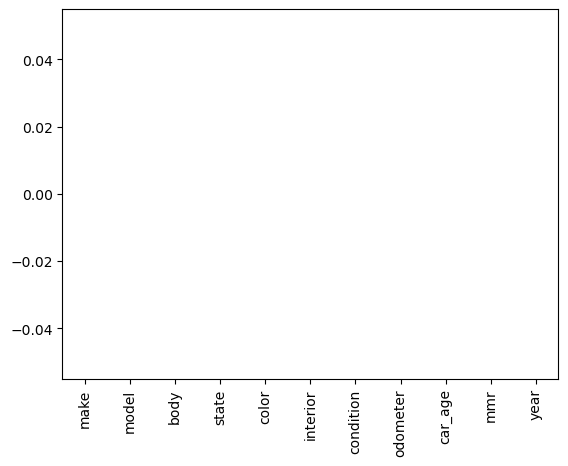

In [320]:
#plot the p-values for visual selection
p_values.plot.bar()